**Notebook contents:**

[Importing the data](#import_data)

[EDA](#eda)
1. [Factors that correlates to the number of new cases](#factor_corr)
* [Data cleaning](#factor_corr_c)
* [Correlation between variables](#corr_var)
* [Dataset variables value over time](#var_time_data)
2. [Herd immunity](#herd_immunity)
* [Data cleaning](#herd_immunity_c)
* [Plot of vaccination progress in Malaysia](#vac_prog)
* [Plot of Malaysia's Herd Immunity percentage](#herd_prec)
3. [State Covid cases](#state_case)
* [Data cleaning](#state_case_c)
* [Plot of new cases for each state over time](#state_case_plot)
4. [State Covid tests](#test_state)
* [Data cleaning](#test_state_c)
* [Plot of total Covid tests by state](#test_state_plot)

[Covid-19 new cases forecast](#new_case_proph)
* [Data preparation](#proph_prep)
* [Hyperparameter tuning](#hyperparameter)
* [Forecast new cases](#forc_new)

[Prediction model](#pred_model)
* [Data preprocessing](#pred_proc)
* [Training and evaluation](#train_eval)




<a id='import_data'></a>
# Importing the data
Since the data is frequently updated, we will grab the data directly from the site instead of having to download the csv files manually to perform the analysis. The other good part about this is that the analysis done in on the latest data provided.

Datasets are obtained from:

* [Ministry of Health Malaysia Github](https://github.com/MoH-Malaysia/covid19-public/)
* [Our World In Data](https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations)

In [1]:
import pandas as pd
import numpy as np
import io
import requests

In [2]:
url="https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/tests_malaysia.csv"
s=requests.get(url).content
tests=pd.read_csv(io.StringIO(s.decode('utf-8')))
tests.to_csv('dataset/tests_malaysia.csv')

In [3]:
url="https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv"
s=requests.get(url).content
cases=pd.read_csv(io.StringIO(s.decode('utf-8')))
cases.to_csv('dataset/cases_malaysia.csv')

In [4]:
url="https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_state.csv"
s=requests.get(url).content
state_cases=pd.read_csv(io.StringIO(s.decode('utf-8')))
state_cases.to_csv('dataset/cases_state.csv')

In [5]:
url="https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/mysejahtera/trace_malaysia.csv"
s=requests.get(url).content
casual_contacts=pd.read_csv(io.StringIO(s.decode('utf-8')))
casual_contacts.to_csv('dataset/trace_malaysia.csv')

In [6]:
url="https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/deaths_malaysia.csv"
s=requests.get(url).content
deaths_public=pd.read_csv(io.StringIO(s.decode('utf-8')))
deaths_public.to_csv('dataset/deaths_malaysia.csv')

In [7]:
url="https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/deaths_state.csv"
s=requests.get(url).content
deaths_state=pd.read_csv(io.StringIO(s.decode('utf-8')))
deaths_state.to_csv('dataset/death_state.csv')

In [8]:
url="https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
s=requests.get(url).content
vaccination_who=pd.read_csv(io.StringIO(s.decode('utf-8')))
vaccination_who.to_csv('dataset/vaccinations.csv')

In [9]:
url="https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/tests_state.csv"
s=requests.get(url).content
tests_state=pd.read_csv(io.StringIO(s.decode('utf-8')))
tests_state.to_csv('dataset/tests_state.csv')

In [10]:
url='https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/static/population.csv'
s=requests.get(url).content
population=pd.read_csv(io.StringIO(s.decode('utf-8')))
population.to_csv('dataset/population.csv')

<a id='eda'></a>
# EDA

<a id='factor_corr'></a>
## 1. Factors that correlates to the number of new cases

<a id='factor_corr_c'></a>
### Data cleaning

In [11]:
#make backup of the original dataframe
df_tests=tests.copy()
df_cases=cases.copy()
df_death_public=deaths_public.copy()
df_casual_contacts=casual_contacts.copy()

In [12]:
#preview data
df_cases.tail()

,date,cases_new,cases_import,cases_recovered,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
603,2021-09-19,14954,11,23469,0.0,8.0,196.0,39.0,3.0,72.0,720.0
604,2021-09-20,14345,43,16814,24.0,4.0,447.0,7.0,1.0,10.0,523.0
605,2021-09-21,15759,27,16650,0.0,3.0,301.0,45.0,15.0,2.0,622.0
606,2021-09-22,14990,5,19702,0.0,8.0,210.0,35.0,49.0,17.0,595.0
607,2021-09-23,13754,4,16628,0.0,1.0,303.0,20.0,7.0,6.0,658.0


In [13]:
#check for null values
print(df_tests.isna().sum())
print('\n')
print(df_cases.isna().sum())
print('\n')
print(df_casual_contacts.isna().sum())
print('\n')
print(df_death_public.isna().sum())

date      0
rtk-ag    0
pcr       0
dtype: int64


date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64


date                0
casual_contacts     0
hide_large         50
hide_small         50
dtype: int64


date              0
deaths_new        0
deaths_new_dod    0
deaths_bid        0
deaths_bid_dod    0
dtype: int64


In [14]:
#check data types
print(df_tests.dtypes)
print('\n')
print(df_cases.dtypes)
print('\n')
print(df_casual_contacts.dtypes)
print('\n')
print(df_death_public.dtypes)

date      object
rtk-ag     int64
pcr        int64
dtype: object


date                        object
cases_new                    int64
cases_import                 int64
cases_recovered              int64
cluster_import             float64
cluster_religious          float64
cluster_community          float64
cluster_highRisk           float64
cluster_education          float64
cluster_detentionCentre    float64
cluster_workplace          float64
dtype: object


date                object
casual_contacts      int64
hide_large         float64
hide_small         float64
dtype: object


date              object
deaths_new         int64
deaths_new_dod     int64
deaths_bid         int64
deaths_bid_dod     int64
dtype: object


In [15]:
#convert date column into datetime
df_tests['date'] = pd.to_datetime(df_tests['date'])
df_cases['date'] = pd.to_datetime(df_cases['date'])
df_casual_contacts['date'] = pd.to_datetime(df_casual_contacts['date'])
df_death_public['date'] = pd.to_datetime(df_cases['date'])

In [16]:
#create dataframe with selected columns
df_cases_new=df_cases[['date','cases_new']]
df_casual_contacts=df_casual_contacts[['date','casual_contacts']]
df_death_total=df_death_public[['date','deaths_new']]

In [17]:
#merge dataframes
new_cases_and_tests =pd.merge(df_cases_new,df_tests,on="date", how='right')
test_cases_contacts =pd.merge(new_cases_and_tests,df_casual_contacts,on="date",how='left')
df_merged =pd.merge(test_cases_contacts,df_death_total,on="date",how='left')

In [18]:
#preview merged dataframe
df_merged.tail()

,date,cases_new,rtk-ag,pcr,casual_contacts,deaths_new
602,2021-09-17,17577.0,66469,40675,43936.0,NaN
603,2021-09-18,15549.0,53716,51101,35972.0,NaN
604,2021-09-19,14954.0,70816,38498,35812.0,NaN
605,2021-09-20,14345.0,120160,45337,44788.0,NaN
606,2021-09-21,15759.0,110875,52789,41393.0,NaN


In [19]:
#check for null values
df_merged.isna().sum()

date                 0
cases_new            1
rtk-ag               0
pcr                  0
casual_contacts    402
deaths_new          51
dtype: int64

In [20]:
#handling null values
#Since theres a substantial amount of missing values,
#we will use iterative imputer. It will estimate the values according to the featues.

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
x=df_merged[['cases_new','casual_contacts','pcr','rtk-ag','deaths_new']]

it_imputer = IterativeImputer(min_value = 0)
y=it_imputer.fit_transform(x)

y = pd.DataFrame(y, columns = x.columns)
pd.DataFrame(y)

cleaned_df =pd.merge(y,df_merged['date'], left_index=True, right_index=True)

pd.DataFrame(cleaned_df)

,cases_new,casual_contacts,pcr,rtk-ag,deaths_new,date
0,0.0,571.084765,2.0,0.0,0.000000,2020-01-24
1,4.0,576.000003,5.0,0.0,2.000000,2020-01-25
2,0.0,573.771209,14.0,0.0,0.000000,2020-01-26
3,0.0,576.009913,24.0,0.0,0.000000,2020-01-27
4,0.0,582.426380,53.0,0.0,1.000000,2020-01-28
...,...,...,...,...,...,...
602,17577.0,43936.000000,40675.0,66469.0,464.590335,2021-09-17
603,15549.0,35972.000000,51101.0,53716.0,416.319642,2021-09-18
604,14954.0,35812.000000,38498.0,70816.0,392.152734,2021-09-19
605,14345.0,44788.000000,45337.0,120160.0,346.279841,2021-09-20


In [21]:
#convert numerical values to integer
cleaned_df[['cases_new','casual_contacts','pcr', 'rtk-ag','deaths_new']]=cleaned_df[['cases_new','casual_contacts','pcr', 'rtk-ag','deaths_new']].astype(int)

In [22]:
#sort values by date
cleaned_df.sort_values(by='date',ascending=True)

,cases_new,casual_contacts,pcr,rtk-ag,deaths_new,date
0,0,571,2,0,0,2020-01-24
1,4,576,5,0,2,2020-01-25
2,0,573,14,0,0,2020-01-26
3,0,576,24,0,0,2020-01-27
4,0,582,53,0,1,2020-01-28
...,...,...,...,...,...,...
602,17577,43936,40675,66469,464,2021-09-17
603,15549,35972,51101,53716,416,2021-09-18
604,14954,35812,38498,70816,392,2021-09-19
605,14345,44788,45337,120160,346,2021-09-20


### Visualization

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

<a id='corr_var'></a>
#### Correlation between variables

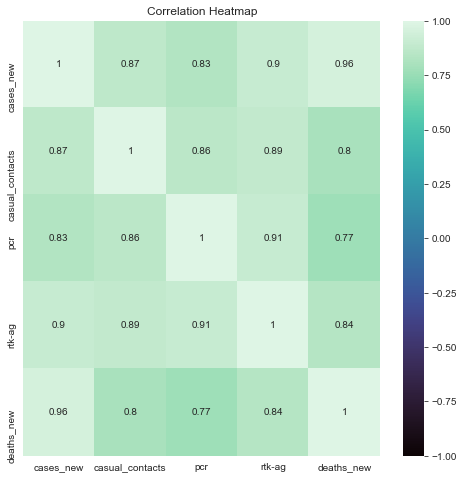

In [24]:
#plot correlation heatmap
corr=cleaned_df.corr()
plt.figure(figsize=(8,8))

sns.heatmap(corr,annot=True,vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show()

**Description:** From the correlation matrix, we can see that there is a high positive correlation between death and new cases. This shows that as the count of new cases increase, the reported new death cases also increases. The amount of new cases is also have a high correlation with the amount of testing done. Among the two tests, rtk-ag test have a higher correlation coefficient than pcr. This may show that there are more positive cases reported by rtk-ag in comparison with pcr. Casual contacts also have a high correlation to the amount of new cases. This shows that casual contacts contributes to the amount of new covid cases.

<a id='var_time_data'></a>
#### Dataset variables value over time

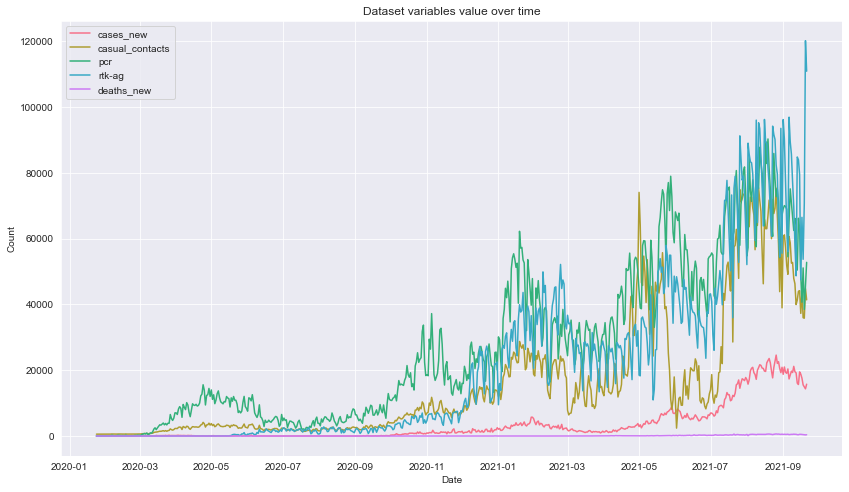

In [25]:
#plot multiple line graph
fig=plt.figure(figsize=(14,8))
plt.title('Dataset variables value over time')
plt.xticks(rotation=0)
sns.lineplot(data=pd.melt(cleaned_df, 'date'), x="date", y='value',hue='variable',palette='husl')
plt.legend()

plt.xlabel('Date')
plt.ylabel('Count')

plt.show()

**Description:** From the plot, we can see that the variables are having an upward trend as time progress. Notice the presence some occasional dips in the number of casual contacts everytime cases hits an all new time high which possibly due to the implementation of stricter Movement Control Order where people are refrained from travelling and even going out. This can be further seen on the filtered linegraph below.

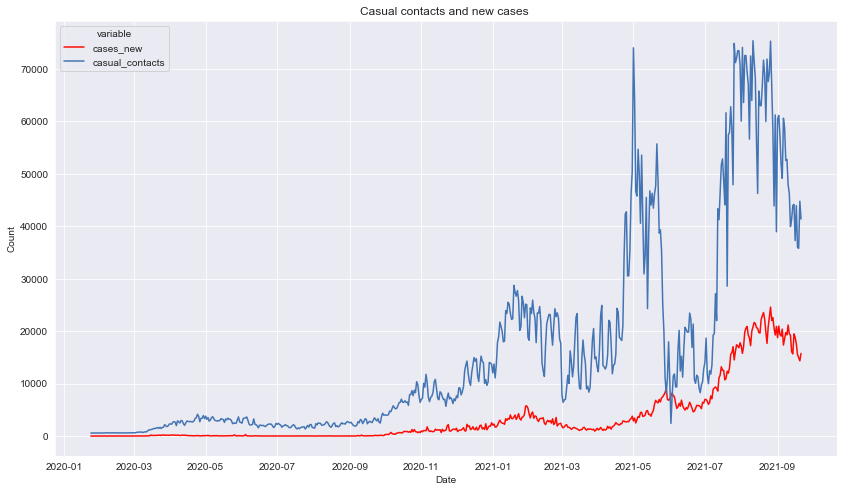

In [26]:
#plot multiple line graph
fig=plt.figure(figsize=(14,8))
plt.title('Casual contacts and new cases ')
plt.xticks(rotation=0)

colors = ["#FF0B04", "#4374B3"]


sns.lineplot(data=pd.melt(cleaned_df[['cases_new','casual_contacts','date']], 'date'),
             x="date",
             y='value',
             hue='variable',
             palette=colors
            )

plt.xlabel('Date')
plt.ylabel('Count')

plt.show()

**Description:** Here we can have a clearer view on the occasional dips in the number of casual contacts everytime cases hits an all new time high as mentioned from the previous description.

<a id='herd_immunity'></a>
## 2. Herd immunity

Based on the government's target, we need to have 80% of the population fully vaccinated against Covid-19 in order to achieve herd immunity.

<a id='herd_immunity_c'></a>
### Data cleaning

In [27]:
#make a backup of the dataframe
df_vaccination = vaccination_who.copy()
df_population = population.copy()

In [28]:
#preview the dataframe
df_vaccination.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0


In [29]:
#preview the dataframe
df_population.head()

,state,idxs,pop,pop_18,pop_60,pop_12
0,Malaysia,0,32657400,23409600,3502000,3147500
1,Johor,1,3781000,2711900,428700,359900
2,Kedah,2,2185100,1540600,272500,211400
3,Kelantan,3,1906700,1236200,194100,210600
4,Melaka,4,932700,677400,118500,86500


In [30]:
#filter column and rows with data for Malaysia
df_population = df_population[df_population['state']=='Malaysia']
df_vaccination = df_vaccination[df_vaccination['iso_code'] =='MYS']

In [31]:
#create new dataframe with selected columns
df_vax_col = df_vaccination[['date', 'total_vaccinations', 'people_vaccinated' , 'people_fully_vaccinated','daily_vaccinations']]

In [32]:
#convert date column to datetime
df_vax_col['date'] = pd.to_datetime(df_vax_col['date'])

<ipython-input-32-087e617b6292>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vax_col['date'] = pd.to_datetime(df_vax_col['date'])


In [33]:
#check for null values
print(df_vax_col.isna().sum())

date                       0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    2
daily_vaccinations         1
dtype: int64


In [34]:
#drop null rows
df_vax_col.dropna(inplace=True)

<ipython-input-34-ef025bb1d682>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vax_col.dropna(inplace=True)


In [35]:
#preview dataframe
df_vax_col.tail()

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
27533,2021-09-19,40375056.0,22003333.0,18453322.0,230267.0
27534,2021-09-20,40664674.0,22099719.0,18648795.0,239191.0
27535,2021-09-21,40925929.0,22226325.0,18786636.0,241660.0
27536,2021-09-22,41247271.0,22351561.0,18986347.0,252022.0
27537,2021-09-23,41573883.0,22482988.0,19180397.0,269781.0


### Visualization

In [36]:
#create pandas series from column
df_pop = df_population['pop']

In [37]:
#merge dataframes
df_vax_herd = df_vax_col.merge(df_pop, how='cross')

In [38]:
#preview dataframes
df_vax_col.tail()

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
27533,2021-09-19,40375056.0,22003333.0,18453322.0,230267.0
27534,2021-09-20,40664674.0,22099719.0,18648795.0,239191.0
27535,2021-09-21,40925929.0,22226325.0,18786636.0,241660.0
27536,2021-09-22,41247271.0,22351561.0,18986347.0,252022.0
27537,2021-09-23,41573883.0,22482988.0,19180397.0,269781.0


<a id='vac_prog'></a>
#### Plot of vaccination progress in Malaysia

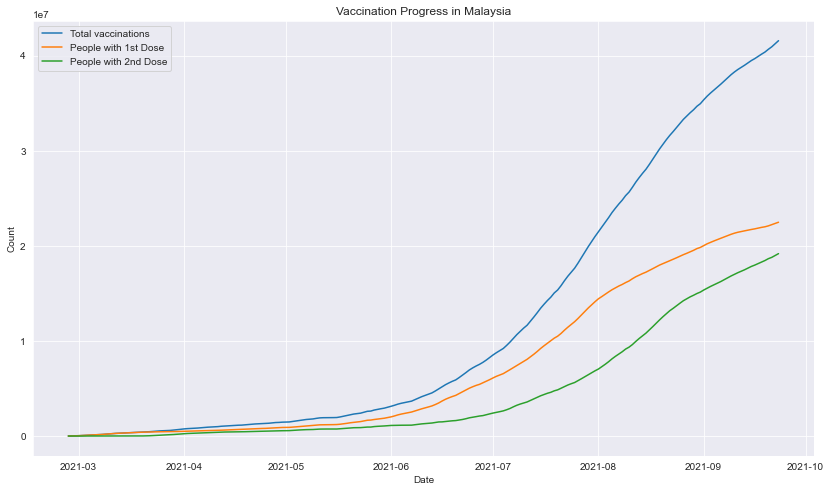

In [39]:
#plot multiple line graph
fig=plt.figure(figsize=(14,8))

date = df_vax_herd['date']
sns.lineplot(x=date, y=df_vax_herd['total_vaccinations'], label = "Total vaccinations")
sns.lineplot(x=date, y=df_vax_herd['people_vaccinated'], label = "People with 1st Dose")
sns.lineplot(x=date, y=df_vax_herd['people_fully_vaccinated'], label = "People with 2nd Dose")

plt.title('Vaccination Progress in Malaysia')

plt.xlabel('Date')
plt.ylabel('Count')

plt.show()

<a id='herd_perc'></a>
#### Plot of Malaysia's Herd Immunity percentage

Equation Herd Immunity is as follows:

    Herd% = (Sum of Fully Vaccinated/Total Popuation) * 100

In [40]:
#calculate herd immunity percentage
df_vax_herd['herd_immunity'] = (df_vax_herd['people_fully_vaccinated'] / df_vax_herd['pop']) * 100

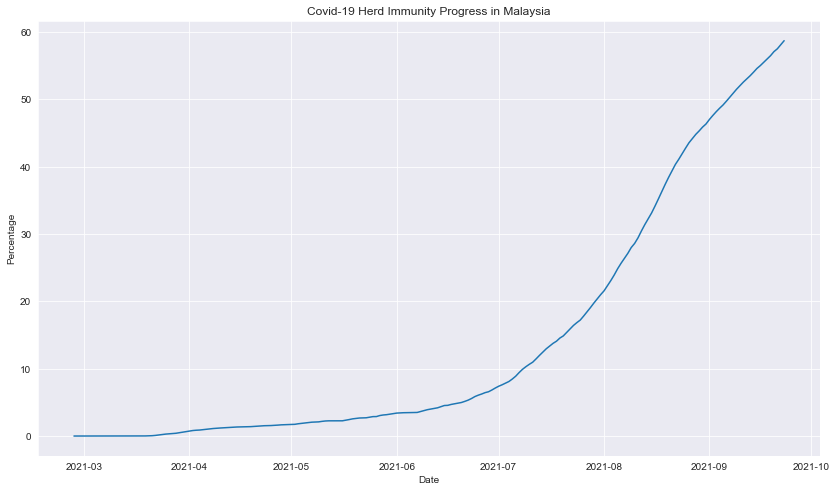

In [41]:
#plot line graph
fig=plt.figure(figsize=(14,8))

sns.lineplot(data=df_vax_herd,x=df_vax_herd['date'],y=df_vax_herd['herd_immunity'])
plt.title("Covid-19 Herd Immunity Progress in Malaysia")
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.show()

**Description:** The vaccine admnistration had exponentially increased with a slight decreased rate aproaching September 2021.

In [42]:
#calculate current herd immunity percentage
herd_immunity = (df_vax_herd['people_fully_vaccinated'].iloc[-1:,] / df_vax_herd['pop'].iloc[-1:,]) * 100

In [43]:
#display herd immunity percentage
print("Malaysia's Herd Immunity Percentage: " + (herd_immunity.round(2).astype(str) + " %"))

209    Malaysia's Herd Immunity Percentage: 58.73 %
dtype: object


<a id='state_case'></a>
## 3. Count of new cases by state

<a id='state_case_c'></a>
### Data Cleaning

In [44]:
#create a copy of the original datafarme
df_state_cases=state_cases.copy()
df_death_public=deaths_public.copy()
df_death_state=deaths_state.copy()

In [45]:
#preview dataframe
df_state_cases.head()

,date,state,cases_import,cases_new,cases_recovered
0,2020-01-25,Johor,4,4,0
1,2020-01-25,Kedah,0,0,0
2,2020-01-25,Kelantan,0,0,0
3,2020-01-25,Melaka,0,0,0
4,2020-01-25,Negeri Sembilan,0,0,0


In [46]:
#convert date to datetime
df_state_cases['date'] = pd.to_datetime(df_state_cases['date'])
df_death_public['date'] = pd.to_datetime(df_death_public['date'])
df_death_state['date'] = pd.to_datetime(df_death_state['date'])

In [47]:
#check for null values
df_state_cases.isna().sum()

date               0
state              0
cases_import       0
cases_new          0
cases_recovered    0
dtype: int64

### Visualization

<a id='state_case_plot'></a>
#### Plot of new cases for each state over time

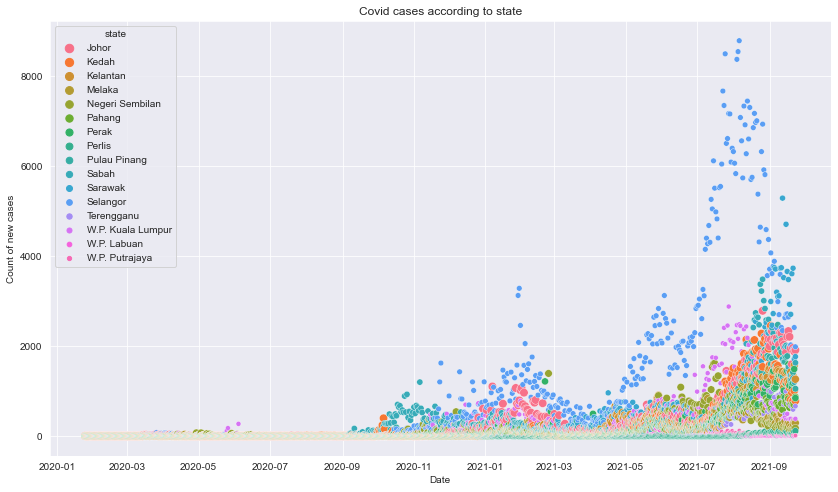

In [48]:
#scatter plot values over time
fig=plt.figure(figsize=(14,8))
plt.title("Covid cases according to state")

sns.scatterplot(y='cases_new', x='date',hue='state',size="state",data=df_state_cases)

plt.xlabel('Date')
plt.ylabel('Count of new cases')

plt.show()

**Description:** The plot shows that Selangor had significatly more cases throughout the time.Around April 2021, there is a low dip after the second ATH that occured around February 2021, and continued to increase exponantially going forward until August before droping to lower count of new cases.

<a id='test_state'></a>
## 4. Count of Covid tests by state

<a id='test_state_c'></a>
### Data cleaning

In [49]:
#make a copy of the dataframe
df_tests_state = tests_state.copy()

In [50]:
#create sum of tests by state
df_ts = df_tests_state.groupby(['state']).sum()

In [51]:
#reset index
df_ts.reset_index(inplace=True)

In [52]:
#create new column with sum of both testing values
df_ts['total_test'] = (df_ts['rtk-ag'] + df_ts['pcr'])

### Visualization

id='test_state_plot'></a>
#### Plot of total Covid tests by state

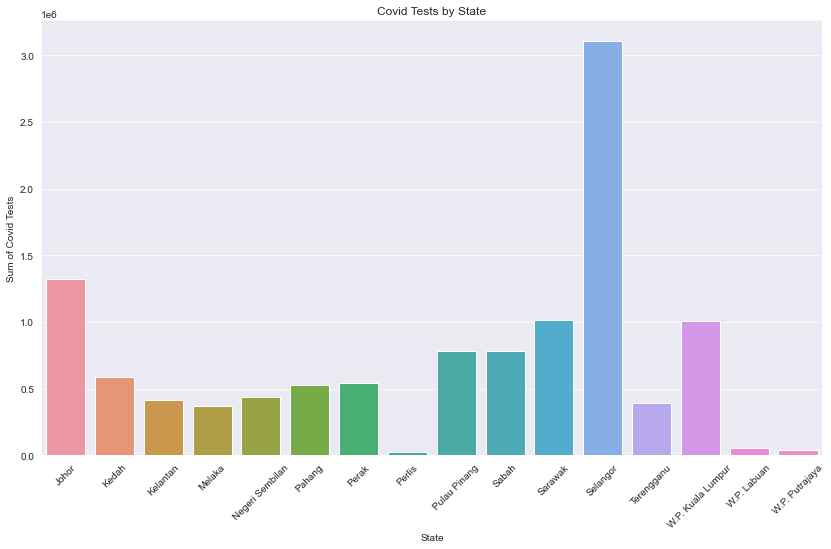

In [53]:
#plot bar chart
fig=plt.figure(figsize=(14,8))
plt.title("Covid Tests by State")
sns.barplot(x="state", y="total_test", data=df_ts)
plt.xlabel('State')
plt.ylabel('Sum of Covid Tests')
plt.xticks(rotation=45)
plt.show()

**Description:** From the Covid Tests by State plot, we can see the top 3 states that have run the most test are Selangor, Johor, and, Sarawak. Despite being near to the Selangor state, W.P Putrajaya had significatly fewer tests done in the area.

<a id='new_case_proph'></a>
# Covid-19 new cases forecast

<a id='proph_prep'></a>
### Data preparation

In [54]:
#Prophet Dependencies
#!pip install pystan==2.19.1.1
#!pip install prophet

In [55]:
#if unable to install
#conda install --override-channels -c main -c conda-forge boost

In [56]:
#import prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [57]:
#make a copy of the original dataframe
pdf = df_cases.copy()
pdf.tail()

,date,cases_new,cases_import,cases_recovered,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
603,2021-09-19,14954,11,23469,0.0,8.0,196.0,39.0,3.0,72.0,720.0
604,2021-09-20,14345,43,16814,24.0,4.0,447.0,7.0,1.0,10.0,523.0
605,2021-09-21,15759,27,16650,0.0,3.0,301.0,45.0,15.0,2.0,622.0
606,2021-09-22,14990,5,19702,0.0,8.0,210.0,35.0,49.0,17.0,595.0
607,2021-09-23,13754,4,16628,0.0,1.0,303.0,20.0,7.0,6.0,658.0


In [58]:
#check data types of the dataframe columns
pdf.dtypes

date                       datetime64[ns]
cases_new                           int64
cases_import                        int64
cases_recovered                     int64
cluster_import                    float64
cluster_religious                 float64
cluster_community                 float64
cluster_highRisk                  float64
cluster_education                 float64
cluster_detentionCentre           float64
cluster_workplace                 float64
dtype: object

In [59]:
#create y and ds dataframe
pdf=pdf[['cases_new','date']]
pdf.columns = ['y', 'ds']

In [60]:
#preview the dataframe
pdf.tail()

,y,ds
603,14954,2021-09-19
604,14345,2021-09-20
605,15759,2021-09-21
606,14990,2021-09-22
607,13754,2021-09-23


<a id='hyperparameter'></a>
### Hyperparameter tuning

In [61]:
#hyperparameter tuning

import itertools    
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


#cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(pdf)  # Fit model with given params
    df_cv = cross_validation(m, initial='467 days', horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 2 forecasts with cutoffs between 2021-05-11 00:00:00 and 2021-06-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000029203F9BD90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 2 forecasts with cutoffs between 2021-05-11 00:00:00 and 2021-06-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002920120D0D0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_s

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  10428.751136
1                     0.001                     0.10  10418.800669
2                     0.001                     1.00  10430.607617
3                     0.001                    10.00  10452.840347
4                     0.010                     0.01   9900.567587
5                     0.010                     0.10   9906.286158
6                     0.010                     1.00   9923.815539
7                     0.010                    10.00   9911.731775
8                     0.100                     0.01   8467.618551
9                     0.100                     0.10   8382.283216
10                    0.100                     1.00   8365.253883
11                    0.100                    10.00   8336.454739
12                    0.500                     0.01   8258.078523
13                    0.500                     0.10   8260.20

In [62]:
#show best parameters for the model
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


<a id='forc_new'></a>
### Forecast new cases

In [81]:
#fit prophet model

m = Prophet(interval_width=0.95,
        yearly_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale=0.5,
        seasonality_prior_scale=1.0
           )

model = m.fit(pdf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
#forecast future values and view the results
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
633,2021-10-19,1403.461091,6968.492023,12876.485030,-1247.636466,4135.503277,8404.598019,8404.598019,8404.598019,-106.751260,-106.751260,-106.751260,8511.349279,8511.349279,8511.349279,0.0,0.0,0.0,9808.059110
634,2021-10-20,1303.622074,6751.202561,12717.137232,-1533.769518,4213.037804,8446.871074,8446.871074,8446.871074,46.806328,46.806328,46.806328,8400.064746,8400.064746,8400.064746,0.0,0.0,0.0,9750.493149
635,2021-10-21,1203.783058,6489.662018,13344.756475,-1778.041413,4361.647403,8478.053838,8478.053838,8478.053838,190.675359,190.675359,190.675359,8287.378479,8287.378479,8287.378479,0.0,0.0,0.0,9681.836896
636,2021-10-22,1103.944041,6150.021220,12962.111912,-2029.850009,4481.939197,8399.993334,8399.993334,8399.993334,226.628366,226.628366,226.628366,8173.364969,8173.364969,8173.364969,0.0,0.0,0.0,9503.937375
637,2021-10-23,1004.105024,5826.671097,12744.813026,-2302.620787,4589.927337,8177.517495,8177.517495,8177.517495,119.416190,119.416190,119.416190,8058.101305,8058.101305,8058.101305,0.0,0.0,0.0,9181.622519


In [83]:
#view for specific date
forecast[forecast['ds']=='2021-09-29']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
613,2021-09-29,3400.24143,12831.961009,15048.728948,3157.467002,3621.190871,10545.699919,10545.699919,10545.699919,46.806328,46.806328,46.806328,10498.893591,10498.893591,10498.893591,0.0,0.0,0.0,13945.941348


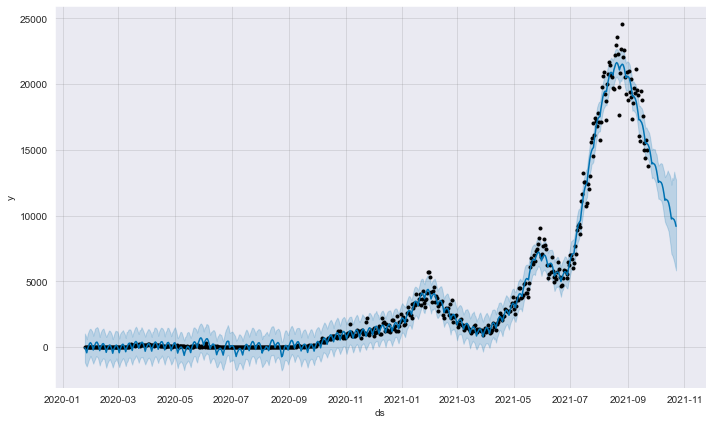

In [84]:
#plot the forecast
plot1 = m.plot(forecast)

**Description:** From the component plot, we can see that there is currently an upward trend in the number of new Covid-19 cases in Malaysia. As for the next 30 days, it is expcted cases to be around 9181 cases with a 5826 lower bound of the uncertainty interval, and 12744 upper bound of the uncertainty interval

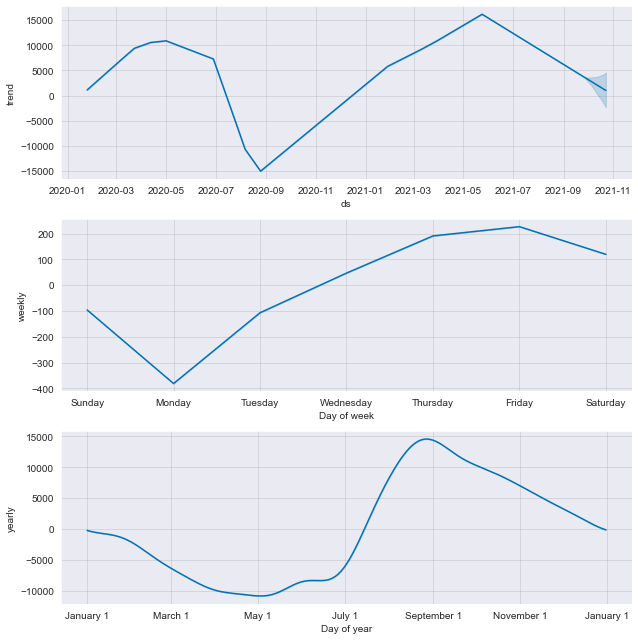

In [85]:
#plot the components
plt2 = m.plot_components(forecast)

**Description:** From the componenets plot, we can see a strong uptrend from the beginning of August 2020 with a slowed rate around March 2021 before starting an increased rate afterwards. We can see that cases are mostly lower at Monday, increases through the week and drops slightly after Friday. There are also more cases happens around August and starts a downward trend going forward.

In [86]:
#save and export model
import pickle
prophet_model_save = 'prophet_model.sav'
pickle.dump(m, open(prophet_model_save, 'wb'))

<a id='pred_model'></a>
# Prediction Model

<a id='pred_proc'></a>
## Data preprocessing

In [105]:
#make a copy of the dataframe
df=cleaned_df.copy()

In [106]:
#drop date column
df.drop('date',axis=1,inplace=True)

In [107]:
#seperate label and features
y=df['cases_new']
X=df.drop('cases_new',axis=1)

In [108]:
#preview the features
X.head()

,casual_contacts,pcr,rtk-ag,deaths_new
0,571,2,0,0
1,576,5,0,2
2,573,14,0,0
3,576,24,0,0
4,582,53,0,1


<a id='train_eval'></a>
## Training and evaluation

In [109]:
#scale the data 
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [137]:
#import the models
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

#define models
rid_model = Ridge(alpha=2.5)
lin_model = LinearRegression()
las_model = Lasso(alpha=25)

#fit model to data
rid_model.fit(X_train, y_train)
lin_model.fit(X_train, y_train)
las_model.fit(X_train, y_train)

Lasso(alpha=25)

In [138]:
#model score
print(rid_model.score(X_train, y_train))
print(lin_model.score(X_train, y_train))
print(las_model.score(X_train, y_train))

0.9590416783141121
0.9590675668329337
0.9590294496609231


In [139]:
#find best alpha value for lasso
from sklearn.linear_model import LassoCV
lass_cv = LassoCV(alphas=[26, 24, 25])

model_cv = lass_cv.fit(X_train, y_train)
model_cv.alpha_

25

In [140]:
#find best alpha value for ridge
from sklearn.linear_model import RidgeCV
regr_cv = RidgeCV(alphas=[2.6, 2.5, 2.4])

model_cv = regr_cv.fit(X_train, y_train)
model_cv.alpha_

2.5

In [141]:
#make predictions
rid_pred = rid_model.predict(X_test)
lin_pred = lin_model.predict(X_test)
las_pred = las_model.predict(X_test)

#r2 score
from sklearn.metrics import r2_score as r2
print(r2(rid_pred, y_test))
print(r2(lin_pred, y_test))
print(r2(las_pred, y_test))

0.9576876101879478
0.9576899372861319
0.9575746475971051


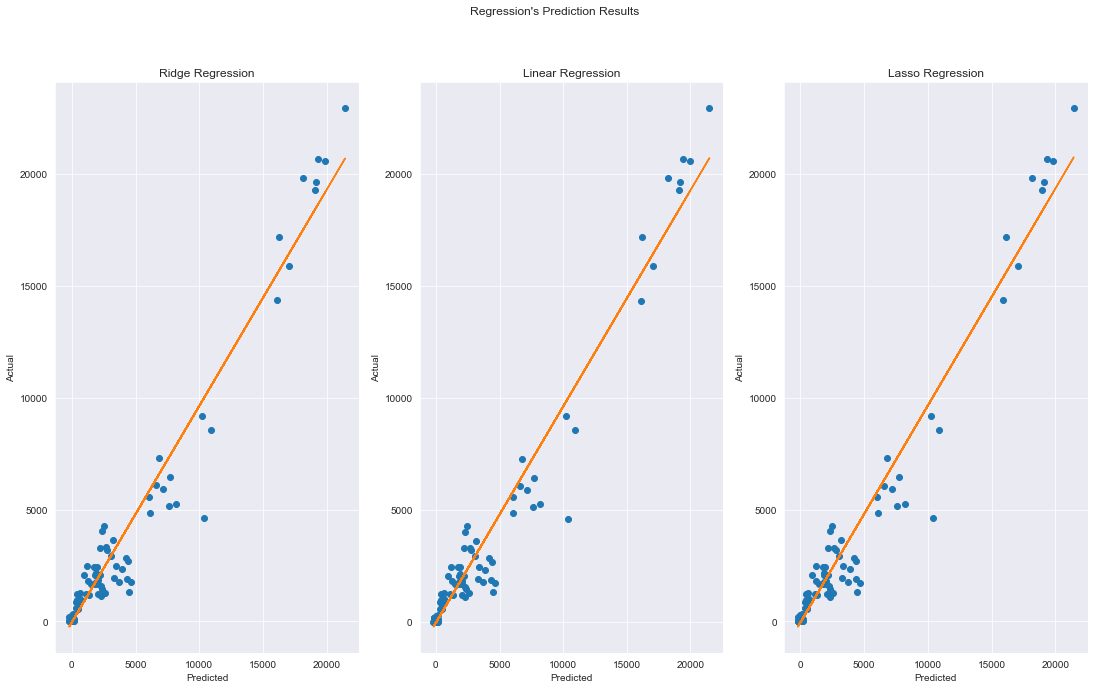

<Figure size 1008x576 with 0 Axes>

In [147]:
#plot prediction results
fig, axs = plt.subplots(1,3)
plt.figure(figsize=(14,8))
fig.set_size_inches(18.5, 10.5)

fig.suptitle("Regression's Prediction Results")

axs[0].plot(rid_pred, y_test,'o')
axs[0].set_title('Ridge Regression')
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')
m, b = np.polyfit(rid_pred, y_test, 1)
axs[0].plot(rid_pred, m*rid_pred + b)


axs[1].plot(lin_pred, y_test,'o')
axs[1].set_title('Linear Regression')
axs[1].set_ylabel('Actual')
axs[1].set_xlabel('Predicted')
m, b = np.polyfit(lin_pred, y_test, 1)
axs[1].plot(lin_pred, m*lin_pred + b)


axs[2].plot(las_pred, y_test,'o')
axs[2].set_title('Lasso Regression')
axs[2].set_ylabel('Actual')
axs[2].set_xlabel('Predicted')
m, b = np.polyfit(las_pred, y_test, 1)
axs[2].plot(las_pred, m*las_pred + b)

plt.show()

**Description:** we can see that most of the models performed well with r2 scores approximately 0.96. From the results, we can see that linear regression performed the best at predicting new cases using this dataset.

Feature: 0, Score: 941.64680
Feature: 1, Score: -63.38715
Feature: 2, Score: 1221.95213
Feature: 3, Score: 3855.68925


C:\Users\Haziq\Anaconda3\envs\prophet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


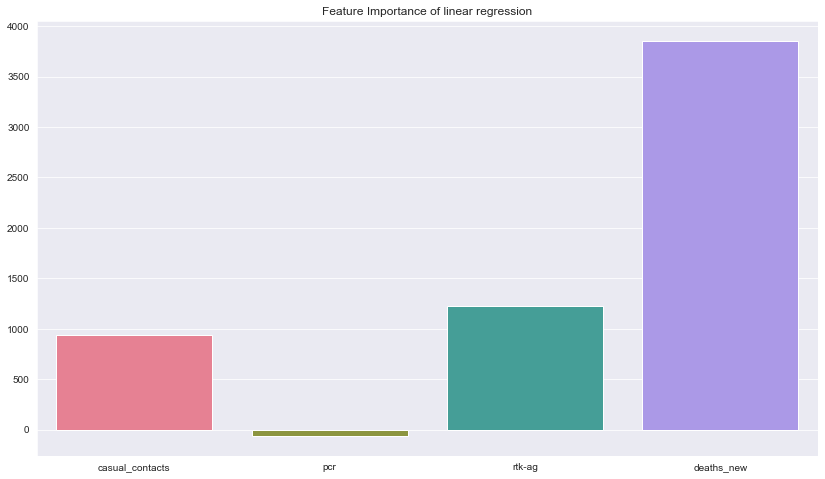

In [143]:
# get importance for linear regression
importance = lin_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(14,8))

sns.barplot([x for x in range(len(importance))], importance,palette="husl")
feature_names = df.columns.drop('cases_new')

#set feature name
plt.xticks(ticks=[0,1,2,3],labels=feature_names)
plt.title("Feature Importance of linear regression")
plt.show()

**Description:** Here we can see the feature importance for the best model which is linear regression. The chart shows that the values of new death cases had the biggest impact in predicting the number of new cases followed by count rtk-ag tests, casual contacts and lastly pcr tests. The dataset had very small number of features so maybe we will include more features in the future.

In [148]:
#save and export model
best_model_save = 'lin_model.sav'
pickle.dump(m, open(best_model_save, 'wb'))